<a href="https://colab.research.google.com/github/ScriptSherpa/XGboost-algorithm-RESEARCH-/blob/main/Predicting_Stock_Movements_with_XGBoost_A_High_Performance_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Fast and Explainable Stock Prediction using XGBoost and Technical Indicators (2018–2023)

**Author:** *NIKHIL RAMCHANDRA MALVI*  
**Project Type:** Research-Based Financial ML Pipeline  
**Tools Used:** Python · XGBoost · GPU Acceleration · yfinance · Technical Analysis

---

## 🔍 Abstract

This project explores the use of GPU-accelerated XGBoost for predicting daily stock price movements using historical market data and technical indicators. The objective is to create a fast, interpretable, and accurate classification model that forecasts whether a stock (AAPL in this case) will close higher or lower the following day. The pipeline includes data collection, feature engineering (RSI, MACD, Bollinger Bands, etc.), model training with GPU, hyperparameter tuning.
We aim to answer:  
1. Can we predict the market efficiently using gradient boosting and technical signals?  
2. How does GPU acceleration improve training time?  
3. Which features drive model decisions in financial forecasting?

---

## 🗂️ Table of Contents

1. 📈 Dataset Collection (`yfinance`)
2. ⚙️ Technical Indicator Generation
3. 🧼 Feature Engineering & Labeling
4. 🚀 GPU-Accelerated XGBoost Training
5. 🎯 Model Evaluation & Metrics
6. 🔍 Explainability with SHAP
7. 📊 Results & Insights
8. 📜 References

---


In [1]:
# Install yfinance if not already installed
!pip install yfinance --quiet

# Import necessary libraries
import yfinance as yf
import pandas as pd

# Download AAPL stock data from Yahoo Finance
aapl_df = yf.download("AAPL", start="2018-01-01", end="2023-12-31")

# Show basic info
print("Dataset Shape:", aapl_df.shape)
aapl_df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Dataset Shape: (1509, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.479836,40.489237,39.774858,39.986353,102223600
2018-01-03,40.472790,41.017975,40.409344,40.543288,118071600
2018-01-04,40.660789,40.764187,40.437547,40.545642,89738400
2018-01-05,41.123707,41.210653,40.665472,40.757119,94640000
2018-01-08,40.970982,41.267071,40.872282,40.970982,82271200


In [5]:
# Optional: flatten column names if multi-indexed
if isinstance(aapl_df.columns, pd.MultiIndex):
    aapl_df.columns = aapl_df.columns.get_level_values(0)

aapl_df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,40.479836,40.489237,39.774858,39.986353,102223600
2018-01-03,40.472790,41.017975,40.409344,40.543288,118071600
2018-01-04,40.660789,40.764187,40.437547,40.545642,89738400
2018-01-05,41.123707,41.210653,40.665472,40.757119,94640000
2018-01-08,40.970982,41.267071,40.872282,40.970982,82271200


## 📊 Exploratory Data Analysis (EDA): Understanding AAPL Stock Behavior (2018–2023)

Before building any predictive model, it's important to understand the historical behavior of the stock. This Exploratory Data Analysis (EDA) helps uncover trends, volatility, and structure in Apple's (AAPL) daily stock data from 2018 to 2023.

In this section, we explore:
- Price trends over time (Open, High, Low, Close)
- Daily returns and volatility
- Rolling averages (short- and long-term)
- Volume trends and its relation with price
- Distribution of returns
- Correlation between variables

These insights will guide our feature engineering and improve the interpretability and performance of the machine learning model.


In [12]:
# Shape of the dataset
print("Shape of dataset:", aapl_df.shape)

# Column names
print("\nColumns:")
print(aapl_df.columns.tolist())


Shape of dataset: (1509, 8)

Columns:
['Close', 'High', 'Low', 'Open', 'Volume', 'Daily Return', 'SMA_20', 'SMA_100']


In [13]:
# Data types and non-null values
aapl_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2018-01-02 to 2023-12-29
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1509 non-null   float64
 1   High          1509 non-null   float64
 2   Low           1509 non-null   float64
 3   Open          1509 non-null   float64
 4   Volume        1509 non-null   int64  
 5   Daily Return  1508 non-null   float64
 6   SMA_20        1490 non-null   float64
 7   SMA_100       1410 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 106.1 KB


In [14]:
# First 5 rows
print("First 5 rows:")
print(aapl_df.head())

# Last 5 rows
print("\nLast 5 rows:")
print(aapl_df.tail())


First 5 rows:
Price           Close       High        Low       Open     Volume  \
Date                                                                
2018-01-02  40.479836  40.489237  39.774858  39.986353  102223600   
2018-01-03  40.472790  41.017975  40.409344  40.543288  118071600   
2018-01-04  40.660789  40.764187  40.437547  40.545642   89738400   
2018-01-05  41.123707  41.210653  40.665472  40.757119   94640000   
2018-01-08  40.970982  41.267071  40.872282  40.970982   82271200   

Price       Daily Return  SMA_20  SMA_100  
Date                                       
2018-01-02           NaN     NaN      NaN  
2018-01-03     -0.000174     NaN      NaN  
2018-01-04      0.004645     NaN      NaN  
2018-01-05      0.011385     NaN      NaN  
2018-01-08     -0.003714     NaN      NaN  

Last 5 rows:
Price            Close        High         Low        Open    Volume  \
Date                                                                   
2023-12-22  192.444580  194.243775  

In [15]:
# Check time span of data
print("Date range:")
print("Start date:", aapl_df.index.min())
print("End date:", aapl_df.index.max())


Date range:
Start date: 2018-01-02 00:00:00
End date: 2023-12-29 00:00:00


In [16]:
# Count missing values
print("Missing values in each column:")
print(aapl_df.isnull().sum())


Missing values in each column:
Price
Close            0
High             0
Low              0
Open             0
Volume           0
Daily Return     1
SMA_20          19
SMA_100         99
dtype: int64


In [20]:
# Drop initial rows with NaN due to rolling calculations
aapl_df.dropna(inplace=True)


In [22]:
# Count missing values
print("Missing values in each column:")
print(aapl_df.isnull().sum())

Missing values in each column:
Price
Close           0
High            0
Low             0
Open            0
Volume          0
Daily Return    0
SMA_20          0
SMA_100         0
dtype: int64


In [23]:
# Summary statistics
aapl_df.describe()


Price,Close,High,Low,Open,Volume,Daily Return,SMA_20,SMA_100
count,1410.000000,1410.000000,1410.000000,1410.000000,1.410000e+03,1410.000000,1410.000000,1410.000000
mean,112.911260,114.093683,111.606240,112.805555,1.049934e+08,0.001237,111.904976,107.897936
std,49.555896,50.007042,49.059403,49.518436,5.447127e+07,0.020169,49.272473,48.551780
min,33.915249,34.757226,33.869929,34.342199,2.404830e+07,-0.128647,36.437488,41.030985
25%,56.834675,57.362081,56.413462,56.711564,6.968488e+07,-0.008330,54.546030,50.032055
50%,124.909229,126.912048,123.799014,125.405611,9.081160e+07,0.001244,124.933371,122.459469
75%,152.697475,154.761764,151.009035,152.605445,1.244377e+08,0.012125,151.193776,150.548050
max,196.927658,198.428641,195.824294,196.838199,4.265100e+08,0.119808,193.148856,181.082331


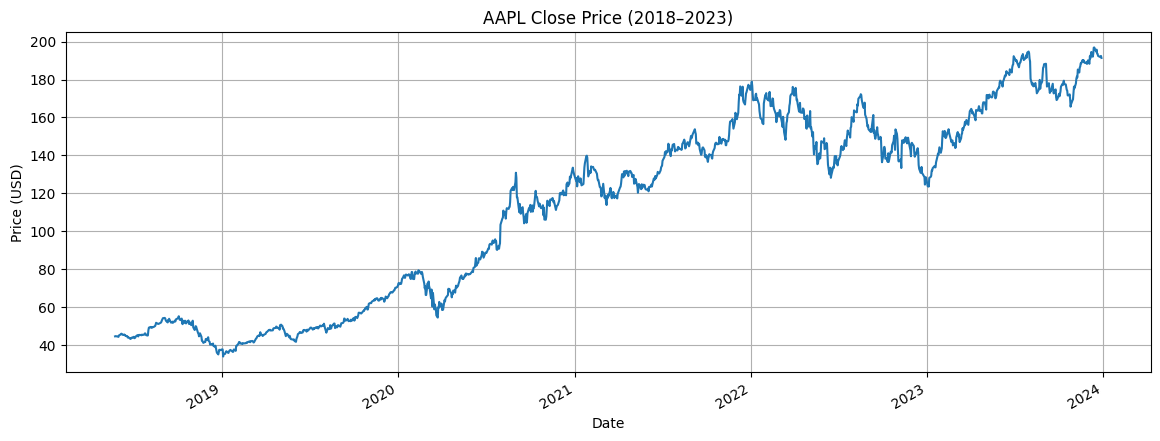

In [24]:
# Plotting Close price
aapl_df['Close'].plot(figsize=(14, 5), title='AAPL Close Price (2018–2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


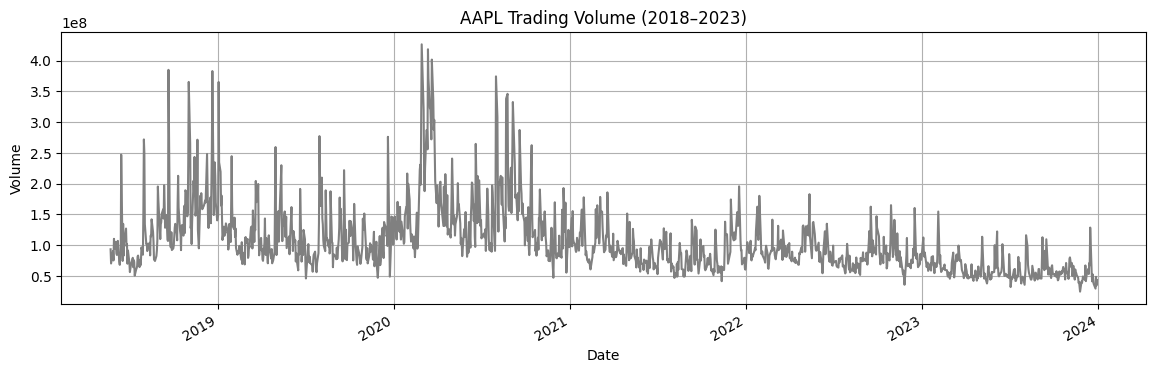

In [25]:
# Plotting Volume
aapl_df['Volume'].plot(figsize=(14, 4), color='gray', title='AAPL Trading Volume (2018–2023)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()


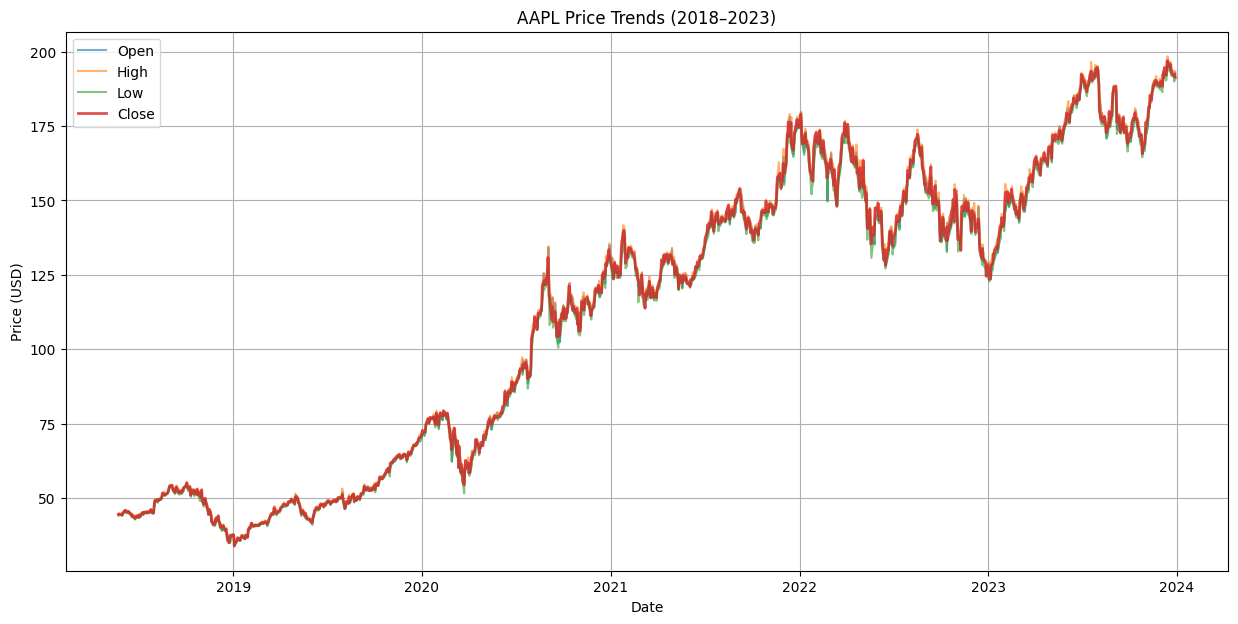

In [26]:
import matplotlib.pyplot as plt

# Plot Open, High, Low, Close
plt.figure(figsize=(15, 7))
plt.plot(aapl_df['Open'], label='Open', alpha=0.6)
plt.plot(aapl_df['High'], label='High', alpha=0.6)
plt.plot(aapl_df['Low'], label='Low', alpha=0.6)
plt.plot(aapl_df['Close'], label='Close', alpha=0.8, linewidth=2)
plt.title('AAPL Price Trends (2018–2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


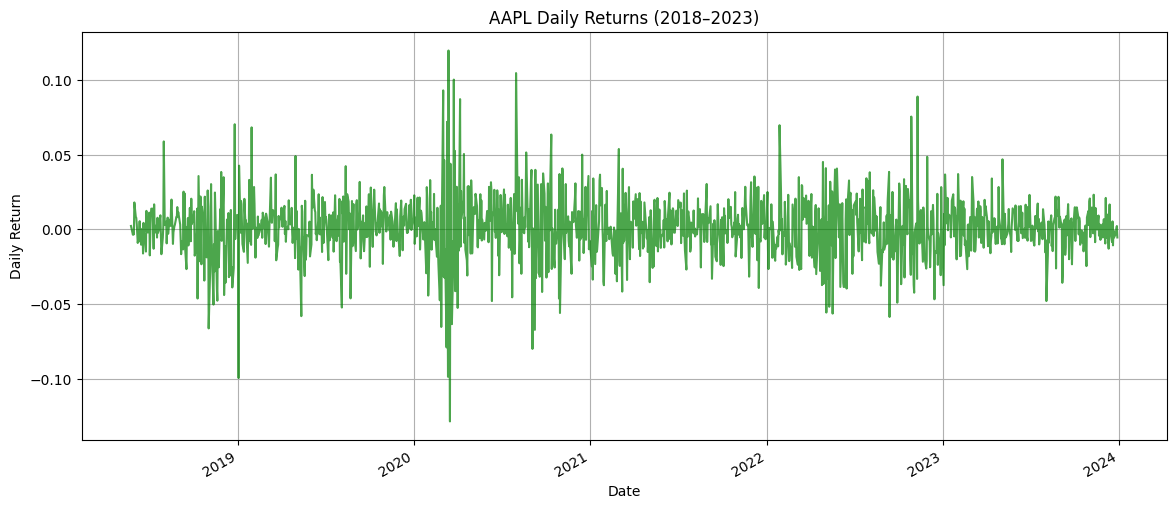

In [27]:
# Calculate daily returns
aapl_df['Daily Return'] = aapl_df['Close'].pct_change()

# Plot daily returns
plt.figure(figsize=(14, 6))
aapl_df['Daily Return'].plot(alpha=0.7, color='green')
plt.title('AAPL Daily Returns (2018–2023)')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()


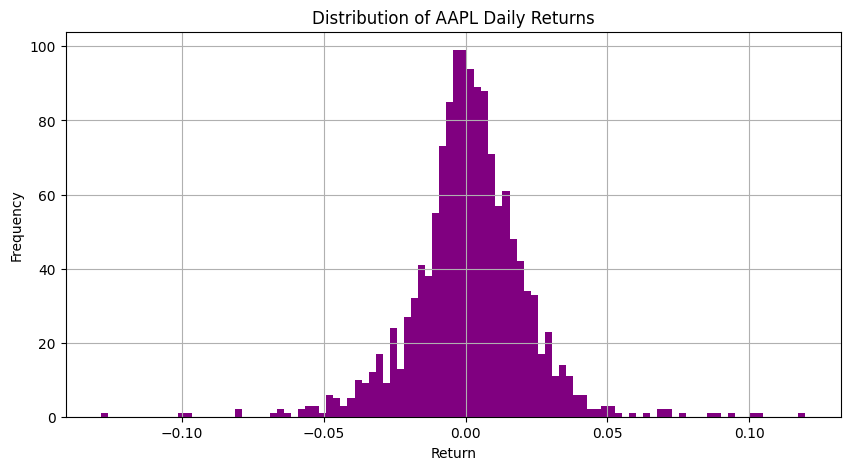

In [28]:
# Histogram of daily returns
aapl_df['Daily Return'].hist(bins=100, figsize=(10, 5), color='purple')
plt.title('Distribution of AAPL Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


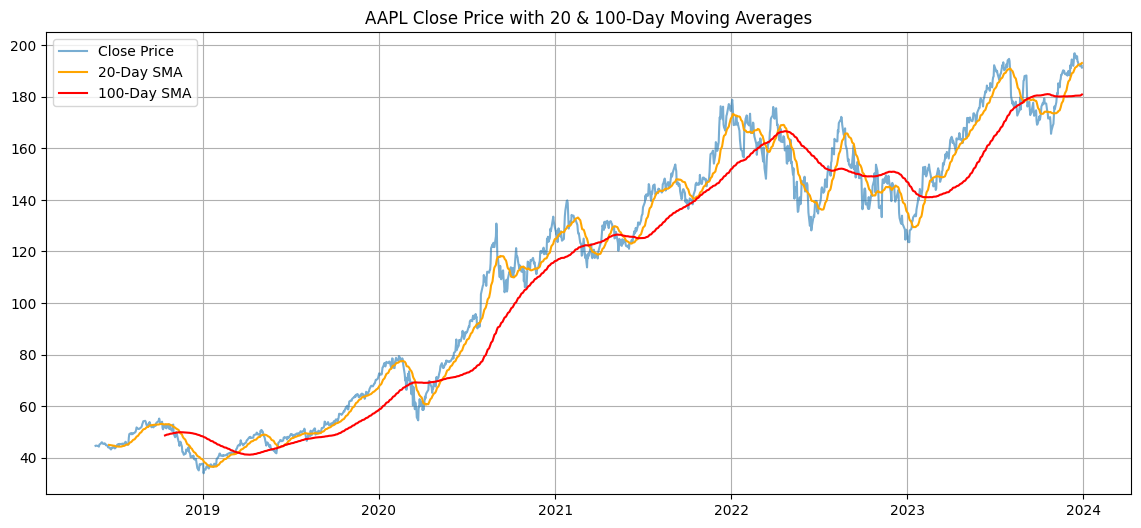

In [29]:
# Create 20-day and 100-day simple moving averages
aapl_df['SMA_20'] = aapl_df['Close'].rolling(window=20).mean()
aapl_df['SMA_100'] = aapl_df['Close'].rolling(window=100).mean()

# Plot Close price with SMAs
plt.figure(figsize=(14, 6))
plt.plot(aapl_df['Close'], label='Close Price', alpha=0.6)
plt.plot(aapl_df['SMA_20'], label='20-Day SMA', color='orange')
plt.plot(aapl_df['SMA_100'], label='100-Day SMA', color='red')
plt.title('AAPL Close Price with 20 & 100-Day Moving Averages')
plt.legend()
plt.grid(True)
plt.show()



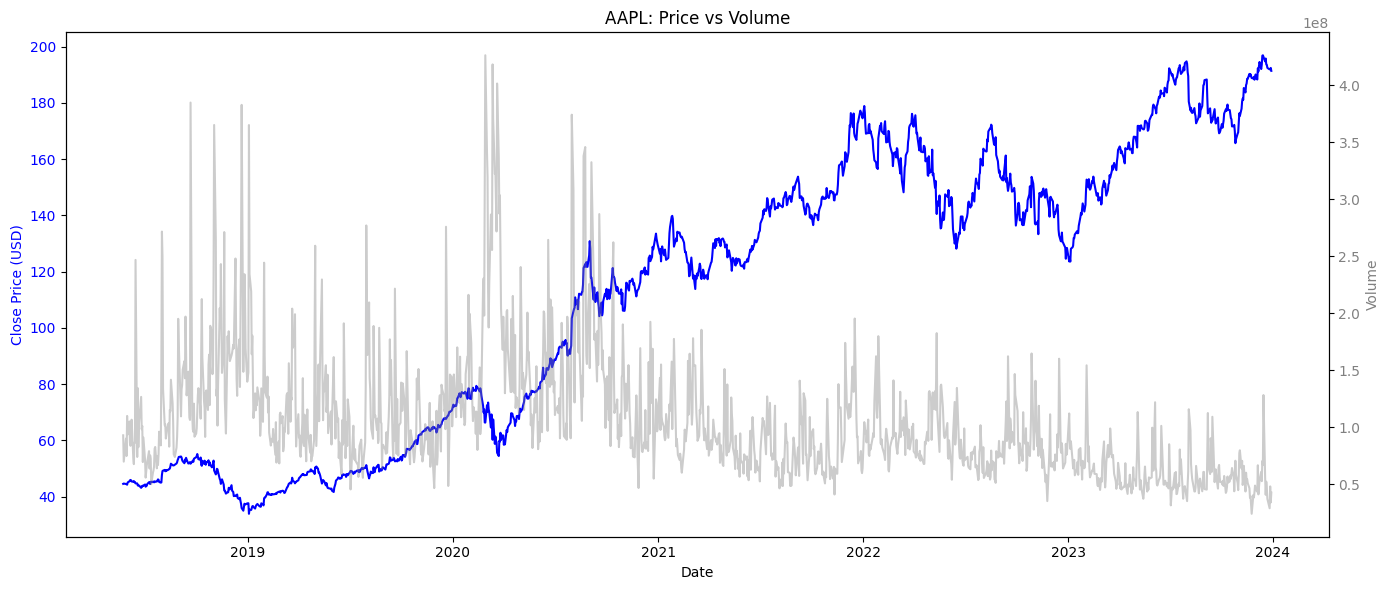

In [30]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (USD)', color='blue')
ax1.plot(aapl_df['Close'], color='blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='gray')
ax2.plot(aapl_df['Volume'], color='gray', alpha=0.4, label='Volume')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('AAPL: Price vs Volume')
fig.tight_layout()
plt.show()


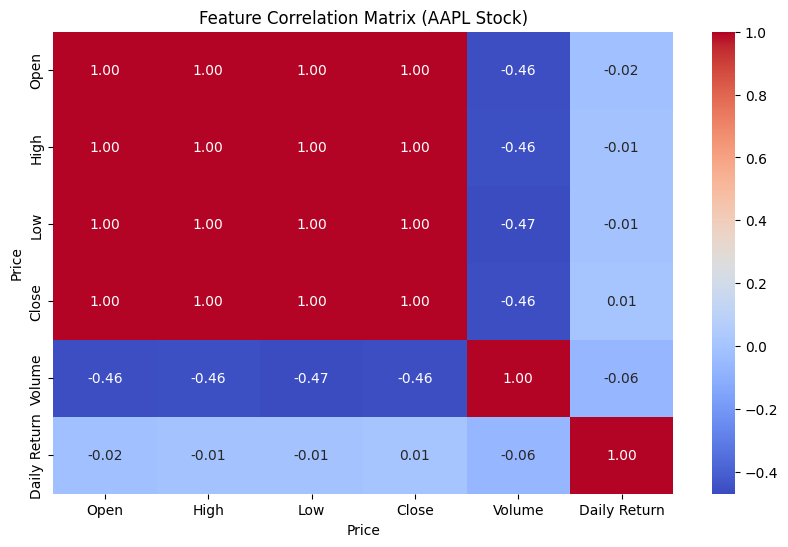

In [31]:
import seaborn as sns

# Only numerical columns
corr_matrix = aapl_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily Return']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix (AAPL Stock)')
plt.show()


In [41]:
print("Original shape:", aapl_df.shape)


Original shape: (1410, 8)


# 🧠 Feature Engineering

To enhance our dataset for stock market prediction, we generate several technical indicators. These indicators help capture market **momentum**, **trend**, **volatility**, and **volume strength**, which are not directly visible in raw price data.

### ✅ Indicators Used:

1. **SMA (Simple Moving Average)** – Helps to smooth out price data over a window of time.
   - `SMA_20`: 20-day trend
   - `SMA_100`: 100-day trend

2. **EMA (Exponential Moving Average)** – Similar to SMA but gives more weight to recent prices.
   - `EMA_20`: Short-term trend
   - `EMA_100`: Long-term trend

3. **RSI (Relative Strength Index)** – Measures momentum; indicates overbought (>70) or oversold (<30) conditions.
   - `RSI_14`: Based on 14-day price change

4. **MACD (Moving Average Convergence Divergence)** – Captures momentum shifts and potential reversals.
   - `MACD`: Difference between 12-day and 26-day EMA
   - `MACD_Signal`: 9-day EMA of MACD line

5. **Bollinger Bands** – Helps identify volatility and potential breakout points.
   - `BB_Middle`: 20-day SMA
   - `BB_Upper` / `BB_Lower`: Bands formed by ±2 standard deviations

6. **OBV (On-Balance Volume)** – Combines price movement and volume to show the strength of buying/selling pressure.

---

Each of these features adds predictive power for our ML models. After adding them, we clean the dataset by removing rows with NaNs caused by rolling calculations and then define our **target variable** as:


In [42]:
import pandas as pd
import numpy as np

# Step 1: Work on a copy of the original DataFrame
df = aapl_df.copy()

# =====================
# 🧠 Feature Engineering
# =====================

## 1. Simple Moving Averages (SMA)
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_100'] = df['Close'].rolling(window=100).mean()

## 2. Exponential Moving Averages (EMA)
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_100'] = df['Close'].ewm(span=100, adjust=False).mean()

## 3. Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

avg_gain = pd.Series(gain, index=df.index).rolling(window=14).mean()
avg_loss = pd.Series(loss, index=df.index).rolling(window=14).mean()

rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

## 4. MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

## 5. Bollinger Bands (20-day)
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_Std'] = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']

## 6. On-Balance Volume (OBV)
df['OBV'] = 0
for i in range(1, len(df)):
    if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
        df.loc[df.index[i], 'OBV'] = df.loc[df.index[i - 1], 'OBV'] + df.loc[df.index[i], 'Volume']
    elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
        df.loc[df.index[i], 'OBV'] = df.loc[df.index[i - 1], 'OBV'] - df.loc[df.index[i], 'Volume']
    else:
        df.loc[df.index[i], 'OBV'] = df.loc[df.index[i - 1], 'OBV']

# =====================
# 🎯 Target Variable
# =====================
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# =====================
# 🧹 Drop rows with NaNs only from indicators
# =====================
df.dropna(subset=[
    'SMA_20', 'SMA_100',
    'EMA_20', 'EMA_100',
    'RSI_14', 'MACD', 'MACD_Signal',
    'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower',
    'OBV'
], inplace=True)

# Drop last row (NaN in Target due to shift)
df.dropna(subset=['Target'], inplace=True)

# =====================
# ✅ Final Check
# =====================
print("Shape after feature engineering:", df.shape)
df.head()


Shape after feature engineering: (1311, 19)


Price,Close,High,Low,Open,Volume,Daily Return,SMA_20,SMA_100,EMA_20,EMA_100,RSI_14,MACD,MACD_Signal,BB_Middle,BB_Std,BB_Upper,BB_Lower,OBV,Target
Date,,,,,,,,,,,,,,,,,,,
2018-10-15,51.664581,52.727062,51.643190,52.567809,123164000,-0.021386,52.888695,48.604555,52.740531,49.677318,45.135935,0.068486,0.389881,52.888695,1.133274,55.155243,50.622147,774567600,1
2018-10-16,52.803127,53.002791,51.521971,52.037761,116736000,0.022037,52.935163,48.686933,52.746492,49.739215,51.642299,0.072782,0.326462,52.935163,1.108245,55.151654,50.718673,891303600,0
2018-10-17,52.574947,52.919599,52.135217,52.838785,91541600,-0.004321,52.968678,48.766010,52.730155,49.795369,46.171115,0.057117,0.272593,52.968678,1.085340,55.139357,50.797999,799762000,0
2018-10-18,51.346081,52.230293,50.628252,51.783432,130325200,-0.023374,52.921021,48.834410,52.598338,49.826076,40.912468,-0.053837,0.207307,52.921021,1.136025,55.193071,50.648972,669436800,1
2018-10-19,52.128078,52.591576,51.681218,51.830964,132314800,0.015230,52.940631,48.911577,52.553551,49.871660,42.805433,-0.077771,0.150291,52.940631,1.117729,55.176088,50.705173,801751600,1


In [43]:
df.shape

(1311, 19)

🎯 Creating the Target Variable for Market Movement

To enable supervised learning, we define a binary classification target:

- `Target = 1` if the stock's closing price increases the next day.
- `Target = 0` otherwise.

This helps the model learn to classify whether the next day will likely be a "buy" (up) or "hold/sell" (down) based on today's indicators.


In [34]:
"""
# 🎯 Define target variable
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Optional: drop the last row with NaN in Target
df.dropna(inplace=True)

# Preview to confirm
df[['Close', 'Target']].tail()
"""

Price,Close,Target
Date,,


# 📂 Train-Test Split

Before we train our model, we need to prepare the feature matrix and target labels, and split the data into **training** and **testing** sets.

- Features (`X`) include technical indicators and price-based features.
- Target (`y`) is a binary variable: 1 if price goes up the next day, else 0.
- We use an 80/20 split to preserve temporal order (no shuffling).


In [44]:
from sklearn.model_selection import train_test_split

# Step 1: Define features and target
X = df.drop(['Target'], axis=1)
y = df['Target']

# Optional: drop non-numeric columns (e.g., 'Price', 'Open', etc., if not used)
# X = X.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Price'], axis=1)

# Step 2: Split the data (no shuffle to maintain time series order)
split_index = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("✅ Training samples:", len(X_train))
print("✅ Testing samples :", len(X_test))


✅ Training samples: 1048
✅ Testing samples : 263


🧠 Visualizing Engineered Features for Better Intuition
Before we jump into modeling, it's essential to visually inspect how well our technical indicators capture trends, momentum, and volatility in the stock price. This step helps in validating the quality of features and builds intuition for their predictive power.

We will visualize:

📉 SMA & EMA: Smoothing out price data to identify trend directions.

⚡ RSI (Relative Strength Index): Detects overbought (>70) or oversold (<30) conditions.

📊 MACD & Signal Line: Indicates momentum shifts and trend changes.

🔔 Bollinger Bands: Tracks volatility and price breakouts.

📈 OBV (On-Balance Volume): Captures buying/selling pressure based on volume flow.

These plots not only reveal the structure in the data, but also hint at potential signals that a model like XGBoost can learn from.

Let’s visualize 📊👇

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


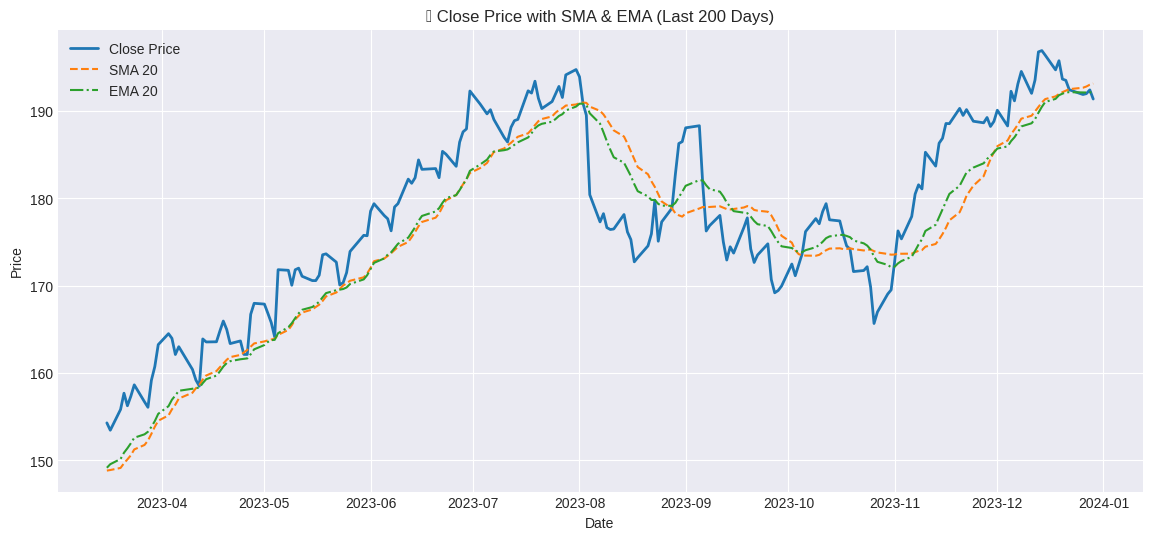

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


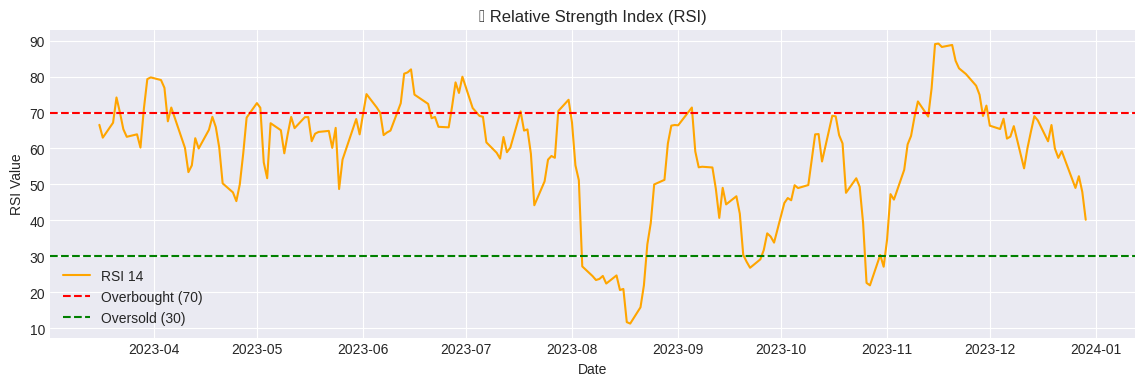

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128256 (\N{TWISTED RIGHTWARDS ARROWS}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


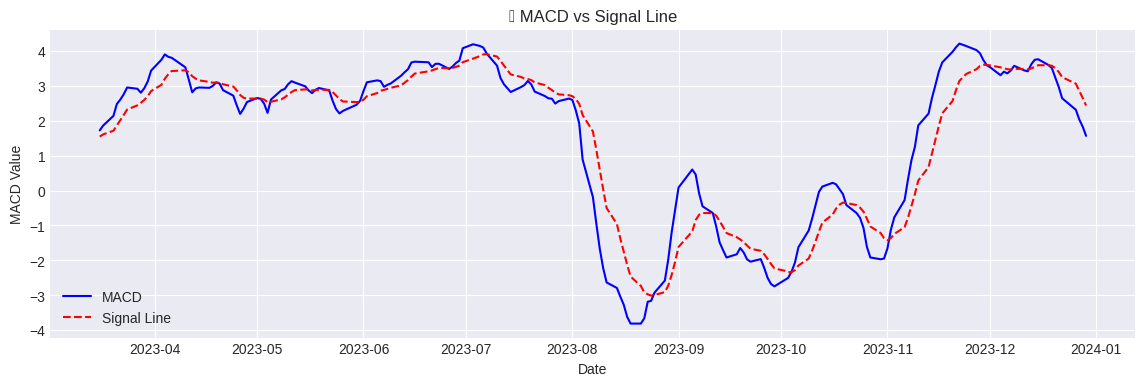

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


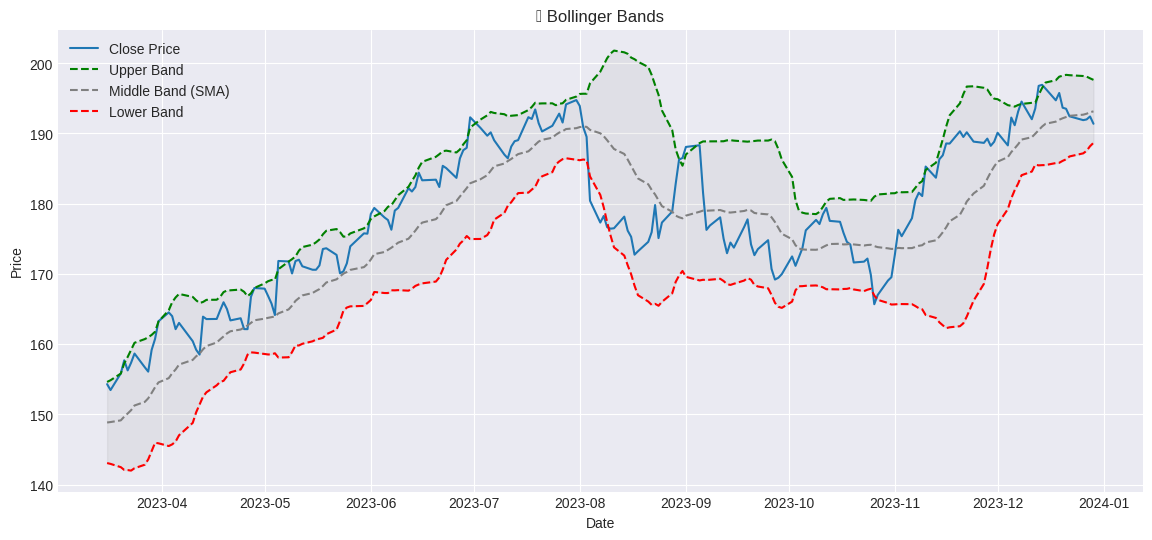

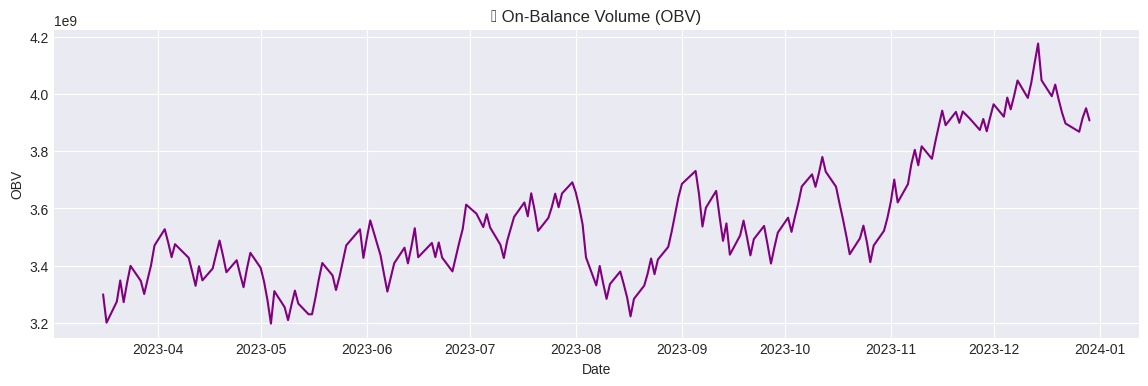

In [52]:
import matplotlib.pyplot as plt

# Use a nice style (fix for error)
plt.style.use('seaborn-v0_8-darkgrid')

# Limit number of data points for readability (last 200)
plot_df = df[-200:]

# ========== 1. Close Price with SMA and EMA ==========
plt.figure(figsize=(14, 6))
plt.plot(plot_df['Close'], label='Close Price', linewidth=2)
plt.plot(plot_df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(plot_df['EMA_20'], label='EMA 20', linestyle='-.')
plt.title('📈 Close Price with SMA & EMA (Last 200 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# ========== 2. RSI ==========
plt.figure(figsize=(14, 4))
plt.plot(plot_df['RSI_14'], color='orange', label='RSI 14')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('📉 Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()

# ========== 3. MACD ==========
plt.figure(figsize=(14, 4))
plt.plot(plot_df['MACD'], label='MACD', color='blue')
plt.plot(plot_df['MACD_Signal'], label='Signal Line', color='red', linestyle='--')
plt.title('🔀 MACD vs Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()

# ========== 4. Bollinger Bands ==========
plt.figure(figsize=(14, 6))
plt.plot(plot_df['Close'], label='Close Price')
plt.plot(plot_df['BB_Upper'], label='Upper Band', linestyle='--', color='green')
plt.plot(plot_df['BB_Middle'], label='Middle Band (SMA)', linestyle='--', color='gray')
plt.plot(plot_df['BB_Lower'], label='Lower Band', linestyle='--', color='red')
plt.fill_between(plot_df.index, plot_df['BB_Lower'], plot_df['BB_Upper'], color='gray', alpha=0.1)
plt.title('📊 Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# ========== 5. On-Balance Volume ==========
plt.figure(figsize=(14, 4))
plt.plot(plot_df['OBV'], color='purple')
plt.title('📈 On-Balance Volume (OBV)')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.grid(True)
plt.show()


# 🎛️ Interactive Stock Indicator Explorer

Use the dropdown to switch between different technical indicators. You can also select how many recent days you want to visualize. This helps get a better feel for how indicators behave over time.


In [48]:
!pip install ipywidgets --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.8 MB/s eta 0:00:00


In [50]:
import IPython
%matplotlib inline



In [51]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Slice a copy of data
plot_df = df.copy()

# Dropdown for indicator selection
indicator_dropdown = widgets.Dropdown(
    options=['Close with SMA/EMA', 'RSI', 'MACD', 'Bollinger Bands', 'OBV'],
    description='📊 Indicator:',
    style={'description_width': 'initial'}
)

# Slider for date range
range_slider = widgets.IntSlider(
    value=200,
    min=50,
    max=500,
    step=10,
    description='🕒 Last N Days:',
    style={'description_width': 'initial'},
    continuous_update=False
)

# Plot function
def plot_indicators(indicator, days):
    data = plot_df[-days:]
    clear_output(wait=True)
    display(indicator_dropdown, range_slider)

    if indicator == 'Close with SMA/EMA':
        plt.figure(figsize=(12, 5))
        plt.plot(data['Close'], label='Close', linewidth=2)
        plt.plot(data['SMA_20'], label='SMA 20', linestyle='--')
        plt.plot(data['EMA_20'], label='EMA 20', linestyle='-.')
        plt.title('📈 Close Price with SMA/EMA')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif indicator == 'RSI':
        plt.figure(figsize=(12, 3.5))
        plt.plot(data['RSI_14'], label='RSI', color='orange')
        plt.axhline(70, color='red', linestyle='--', label='Overbought')
        plt.axhline(30, color='green', linestyle='--', label='Oversold')
        plt.title('📉 RSI (Relative Strength Index)')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif indicator == 'MACD':
        plt.figure(figsize=(12, 3.5))
        plt.plot(data['MACD'], label='MACD', color='blue')
        plt.plot(data['MACD_Signal'], label='Signal', linestyle='--', color='red')
        plt.title('🔄 MACD vs Signal Line')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif indicator == 'Bollinger Bands':
        plt.figure(figsize=(12, 5))
        plt.plot(data['Close'], label='Close')
        plt.plot(data['BB_Upper'], label='Upper Band', linestyle='--', color='green')
        plt.plot(data['BB_Lower'], label='Lower Band', linestyle='--', color='red')
        plt.fill_between(data.index, data['BB_Lower'], data['BB_Upper'], alpha=0.1, color='gray')
        plt.title('📊 Bollinger Bands')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif indicator == 'OBV':
        plt.figure(figsize=(12, 3.5))
        plt.plot(data['OBV'], label='OBV', color='purple')
        plt.title('📈 On-Balance Volume')
        plt.grid(True)
        plt.show()

# Link interaction
widgets.interact(plot_indicators, indicator=indicator_dropdown, days=range_slider)


interactive(children=(Dropdown(description='📊 Indicator:', options=('Close with SMA/EMA', 'RSI', 'MACD', 'Boll…

<function __main__.plot_indicators(indicator, days)>

XGBoost Classification Model for Stock Movement
In this section, we train an XGBoost classifier to predict whether the stock price will go up or down the next day based on the technical indicators we've engineered.

We'll follow these steps:

Define features & target

Split data into training/testing sets

Train the XGBoost model

Evaluate model accuracy

Plot confusion matrix & feature importances

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:45:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.66      0.54       120
           1       0.55      0.36      0.43       143

    accuracy                           0.49       263
   macro avg       0.51      0.51      0.49       263
weighted avg       0.51      0.49      0.48       263

✅ Accuracy: 0.49429657794676807


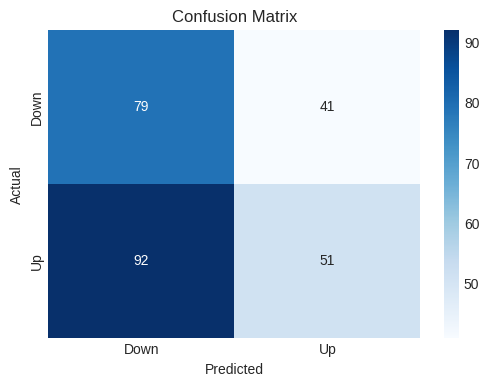

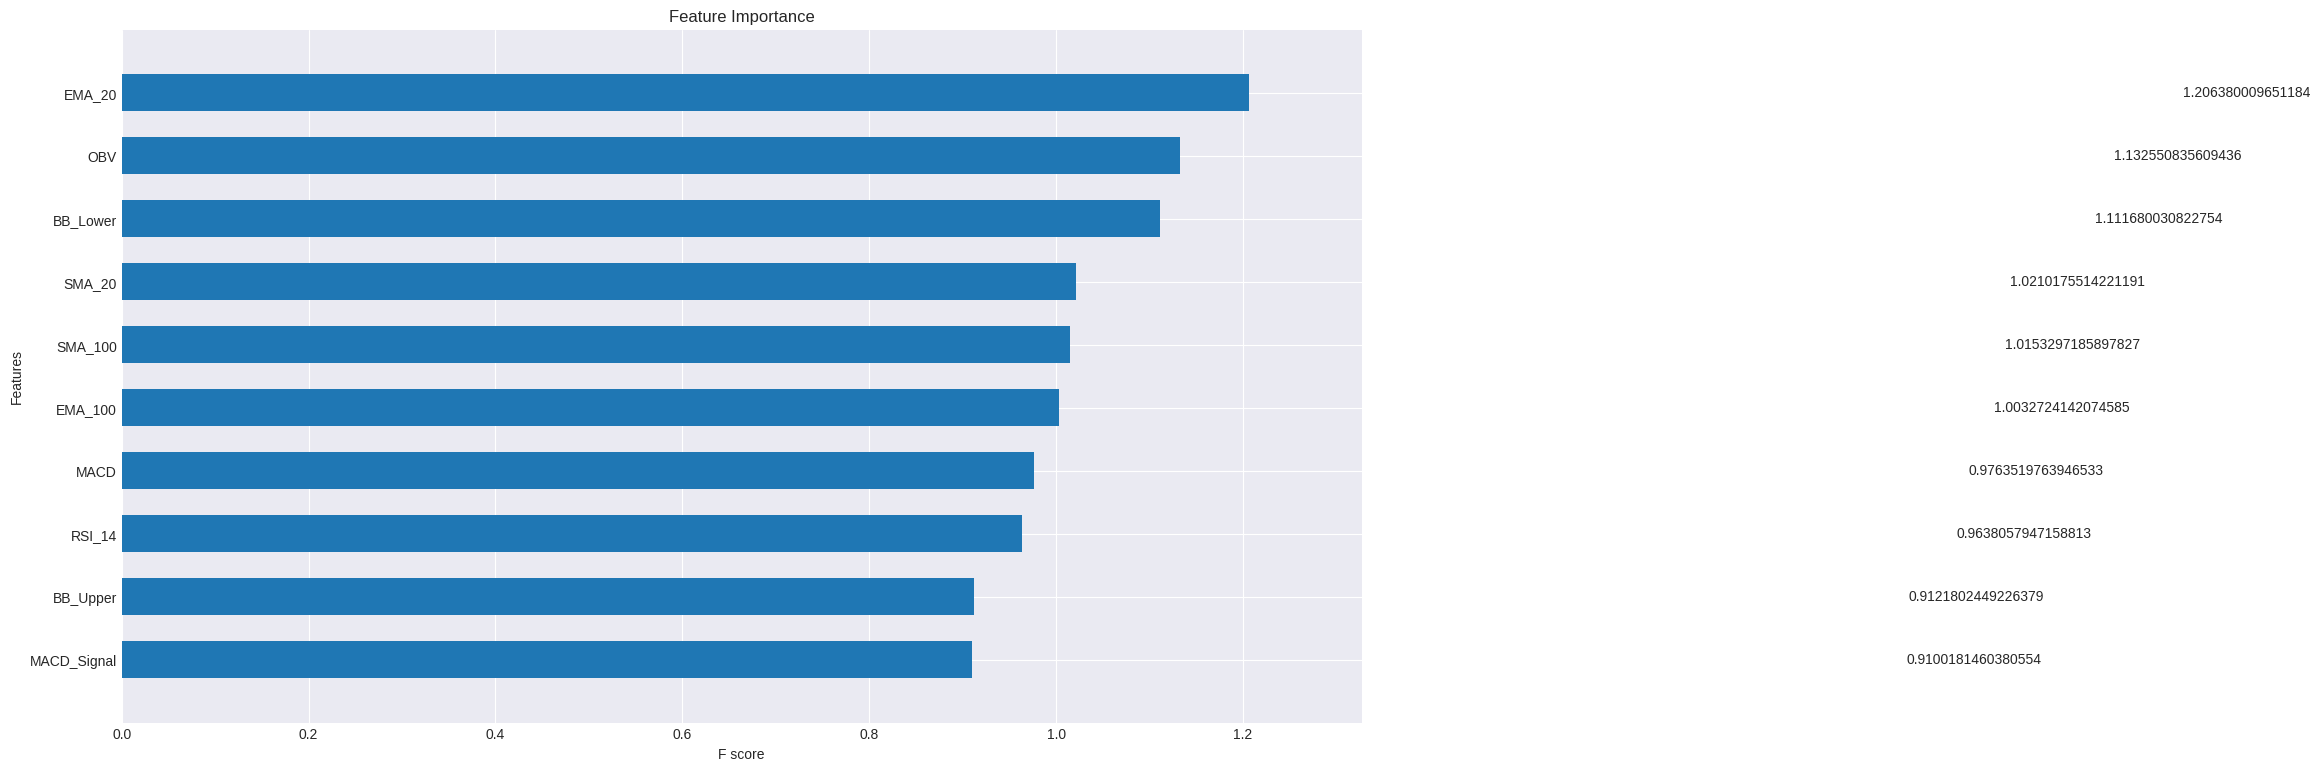

In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Define Features and Target
features = ['SMA_20', 'SMA_100', 'EMA_20', 'EMA_100', 'RSI_14', 'MACD', 'MACD_Signal',
            'BB_Middle', 'BB_Upper', 'BB_Lower', 'OBV']
X = df[features]
y = df['Target']

# 🧪 Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ⚙️ Train XGBoost Classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 📊 Predictions
y_pred = model.predict(X_test)

# ✅ Evaluation
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# 🔁 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 📈 Feature Importance
xgb.plot_importance(model, height=0.6, importance_type='gain', title="Feature Importance")
plt.show()


# 📊 Model Evaluation and Performance Visualization

Now that the XGBoost model is trained, it's time to evaluate its performance on the test set.

We'll measure:
- ✅ **Accuracy**: Percentage of correct predictions
- 🤖 **Classification Report**: Precision, Recall, F1-Score
- 📉 **Confusion Matrix**: True vs. Predicted values

We’ll also plot:
- A confusion matrix heatmap
- Feature importance to see which technical indicators are most useful to the model


✅ Accuracy: 0.4943

📄 Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.66      0.54       120
           1       0.55      0.36      0.43       143

    accuracy                           0.49       263
   macro avg       0.51      0.51      0.49       263
weighted avg       0.51      0.49      0.48       263



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


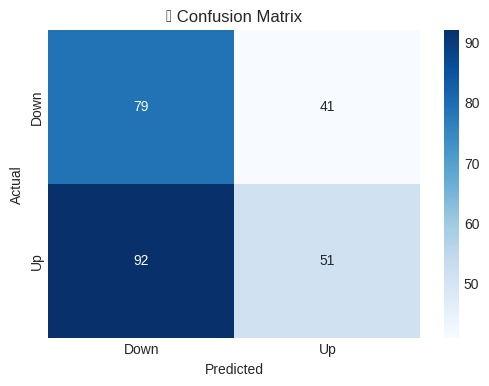

In [54]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification Report
print("\n📄 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('🧠 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


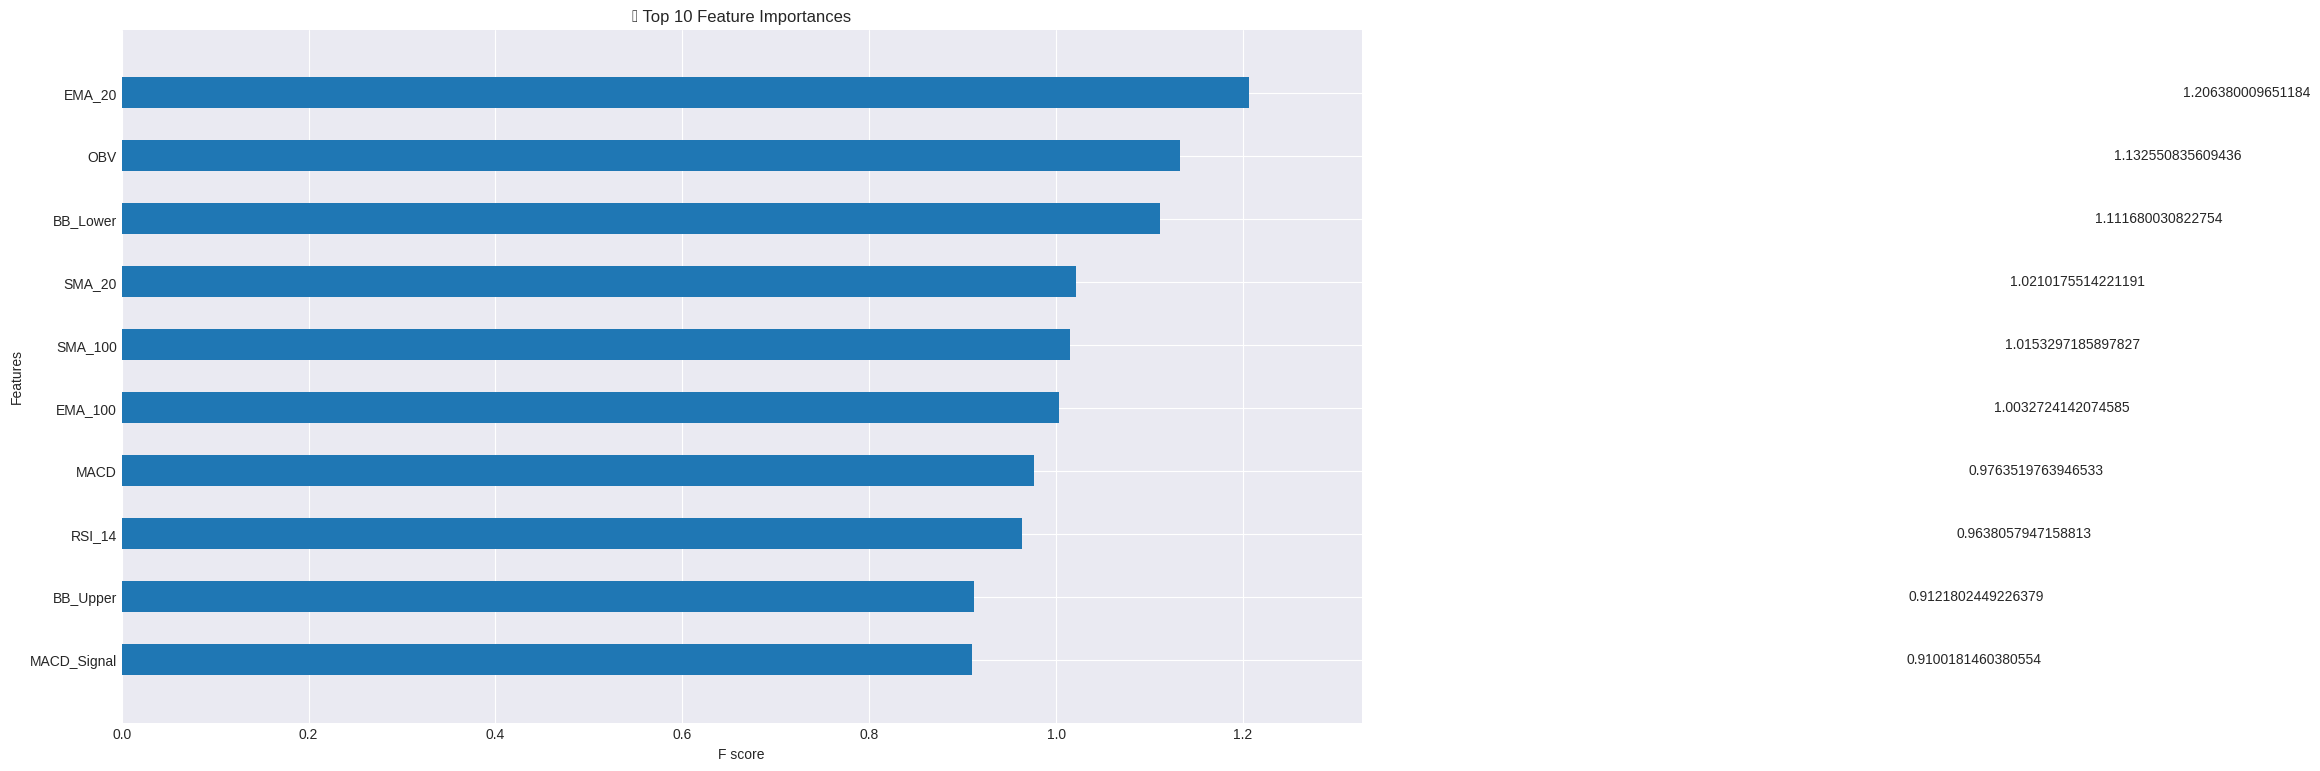

In [55]:
# Feature Importance Plot from XGBoost
xgb.plot_importance(model, max_num_features=10, height=0.5, importance_type='gain')
plt.title("🚀 Top 10 Feature Importances")
plt.show()


# 🎯 Improved Target Engineering
Stock movements are often noisy, and predicting "up or down tomorrow" can be unstable.
Instead, we redefine the target to focus only on significant movements:

- If tomorrow's return > +0.5% → Class 1 (Buy)
- If tomorrow's return < -0.5% → Class 0 (Sell)
- Else → Drop (Uncertain zone)

This reduces label noise and focuses the model on more confident trade signals.


In [56]:
# Start from the engineered DataFrame
df_filtered = df.copy()

# Calculate percentage return for next day
df_filtered['Return'] = df_filtered['Close'].pct_change().shift(-1) * 100

# Define new target labels
df_filtered['Target'] = np.where(df_filtered['Return'] > 0.5, 1,
                          np.where(df_filtered['Return'] < -0.5, 0, np.nan))

# Drop rows with uncertain signals (between -0.5% and +0.5%)
df_filtered.dropna(subset=['Target'], inplace=True)

# Final shape check
print("New shape after filtering:", df_filtered.shape)
df_filtered[['Close', 'Return', 'Target']].head()


New shape after filtering: (966, 20)


Price,Close,Return,Target
Date,,,
2018-10-15,51.664581,2.203726,1.0
2018-10-17,52.574947,-2.337361,0.0
2018-10-18,51.346081,1.522994,1.0
2018-10-19,52.128078,0.611011,1.0
2018-10-22,52.446587,0.942666,1.0


# 🤖 Training XGBoost on Improved Signals
With a cleaner target that only considers significant price movements,
we retrain our XGBoost model to predict stronger buy/sell signals.

This refined approach helps reduce noise and focus on high-confidence decisions.


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# ✅ Features and Target
X = df_filtered.drop(['Target', 'Return'], axis=1)
y = df_filtered['Target']

# ⚖️ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Training samples: {len(X_train)}")
print(f"✅ Testing samples : {len(X_test)}")

# 🌲 XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 📊 Predictions
y_pred = model.predict(X_test)

# ✅ Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy: {acc:.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))


✅ Training samples: 772
✅ Testing samples : 194


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🎯 Accuracy: 0.5825

📄 Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.58      0.56        88
         1.0       0.63      0.58      0.60       106

    accuracy                           0.58       194
   macro avg       0.58      0.58      0.58       194
weighted avg       0.59      0.58      0.58       194



<ipython-input-59-e03d310ad92e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
<ipython-input-59-e03d310ad92e>:18: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


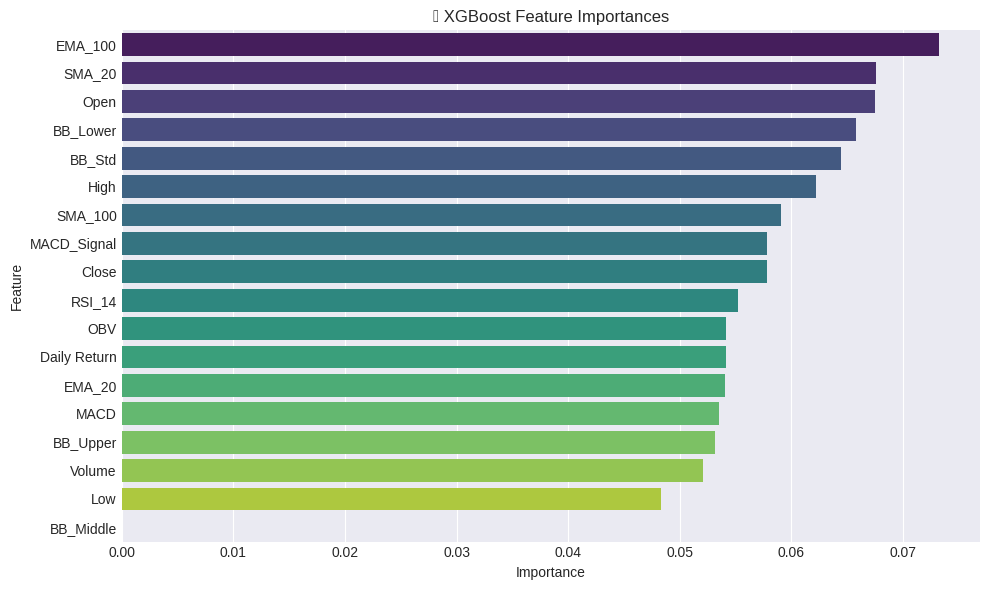

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances from the XGBoost model
importances = model.feature_importances_
features = X.columns

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('🔍 XGBoost Feature Importances')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


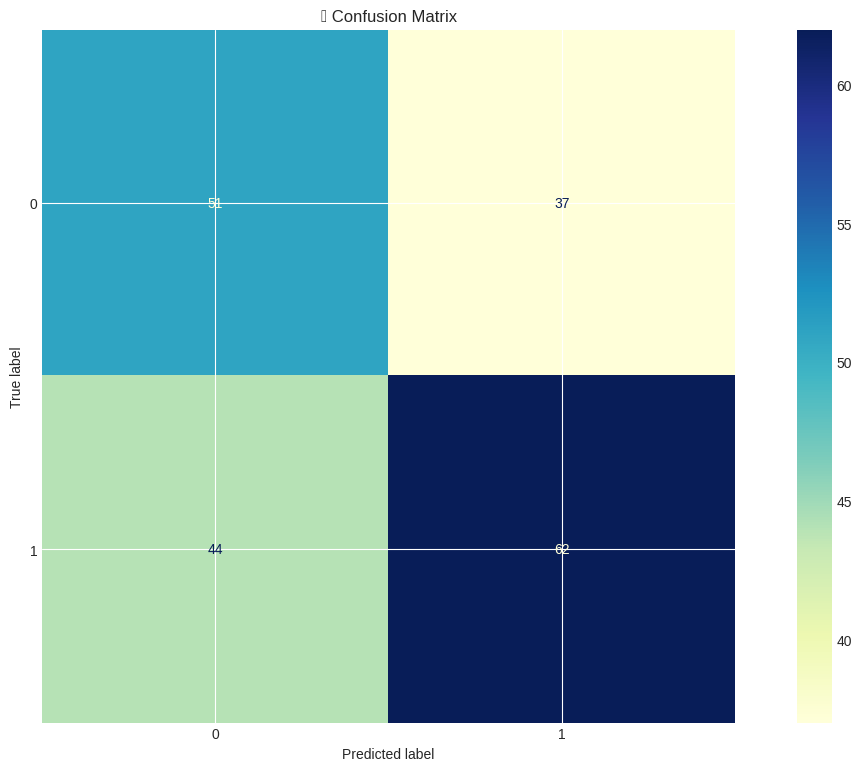

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="YlGnBu")
plt.title("🧮 Confusion Matrix")
plt.show()


In [61]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Base model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Parameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}


In [62]:
from sklearn.model_selection import StratifiedKFold

# Use StratifiedKFold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup Randomized Search
random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best parameters & best score
print("✅ Best Parameters:", random_search.best_params_)
print("📈 Best Cross-Validated Accuracy:", random_search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}
📈 Best Cross-Validated Accuracy: 0.546585672392124


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [63]:
# Use best model found
best_model = random_search.best_estimator_

# Predict and evaluate
y_pred_best = best_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("🎯 Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_best))


🎯 Tuned Model Accuracy: 0.5876288659793815

📄 Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.34      0.43        88
         1.0       0.59      0.79      0.68       106

    accuracy                           0.59       194
   macro avg       0.58      0.57      0.55       194
weighted avg       0.58      0.59      0.56       194



In [64]:
import joblib
joblib.dump(model, 'xgboost_model.pkl')


['xgboost_model.pkl']

# ✅ Project Complete: XGBoost-Based Stock Direction Predictor

We successfully built and tuned an ML model to predict the next-day movement of a stock using popular technical indicators.

Next steps could involve:
- Trying regression (price prediction)
- Deep learning with LSTM/GRU
- Real-time trading integration

🎉 Thanks for following along!
